# Super Mario with Reinforcement Learning

## 1. Import Packages

In [34]:
%pip install nes_py gym_super_mario_bros stable-baselines3[extra]

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: tqdm>=4.48.2 in c:\programdata\anaconda3\lib\site-packages (from nes_py) (4.62.3)



In [19]:
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from nes_py.wrappers import JoypadSpace

### 1.1 Create Environment

In [20]:
env = gym_super_mario_bros.make("SuperMarioBros-v0")
env = JoypadSpace(env, SIMPLE_MOVEMENT) # simplify controls

In [21]:
print(f"number of actions = {env.action_space}")
print(f"random action = {SIMPLE_MOVEMENT[env.action_space.sample()]}")
print(f"observation frame = {env.observation_space.shape}")

number of actions = Discrete(7)
random action = ['right']
observation frame = (240, 256, 3)


### 1.2 Test Environment

In [22]:
def test_env():
    done = True

    for step in range(100000):
        # restart game
        if done: env.reset()

        # take a random action & render game
        state, reward, done, info = env.step(env.action_space.sample())
        env.render()

    env.close()

## 2. Preprocess Environment

In [23]:
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from gym.wrappers import FrameStack, GrayScaleObservation
import matplotlib.pyplot as plt

In [24]:
env = gym_super_mario_bros.make("SuperMarioBros-v0")

# simplify controls
env = JoypadSpace(env, SIMPLE_MOVEMENT) 

# gray scale observation
env = GrayScaleObservation(env, keep_dim=True)

# dummy environment
env = DummyVecEnv([lambda: env])

# stack frames, allows for some context
env = VecFrameStack(env, 4, channels_order="last")

### 2.1 Visualize Environment

In [25]:
# each preprocessing step changes the data
state = env.reset()
state.shape

(1, 240, 256, 4)

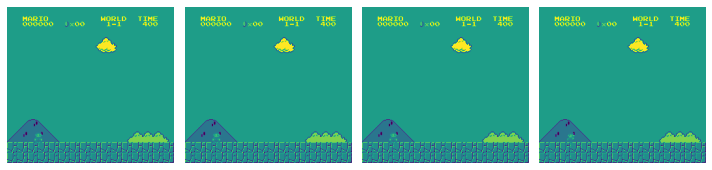

In [26]:
for _ in range(4): 
    state, reward, done, info = env.step([env.action_space.sample()])

plt.figure(figsize=(10, 8))

for idx in range(state.shape[-1]):
    plt.subplot(1, 4, idx + 1)
    plt.axis("off")
    plt.imshow(state[0][:, :, idx])

env.reset()

plt.tight_layout()
plt.show()

## 3. Build Model

In [27]:
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3 import PPO
import os

### 3.1 Save Model Callback

In [28]:
class TrainLogCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainLogCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, "mario_agent")
            self.model.save(model_path)

### 3.2 Create PPO Model

In [29]:
CHECKPOINT_DIR = "model"
LOGS_DIR = "logs"

In [30]:
train_callback = TrainLogCallback(1_000, CHECKPOINT_DIR)
model = PPO("CnnPolicy", env, verbose=1, 
    tensorboard_log=LOGS_DIR, 
    learning_rate=0.000001, 
    n_steps=512)

Using cuda device
Wrapping the env in a VecTransposeImage.


Ideally you want to see `explained_variance` increasing and all of the losses to decrease.

In [ ]:
model.learn(total_timesteps=1_000_000, callback=train_callback)

In [32]:
model_path = os.path.join(CHECKPOINT_DIR, "mario_agent_backup")
model.save(model_path)

## 4. Evaluate Model

In [35]:
%tensorboard --logdir=logs --host localhost --port 8888

UsageError: Line magic function `%tensorboard` not found.


In [36]:
model = PPO.load("model/mario_agent_backup.zip")

In [37]:
state = env.reset()
while True:
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()

c:\ProgramData\Anaconda3\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


KeyboardInterrupt: 

In [38]:
env.close()